In [45]:
import os
import copy
import glob
import opensim
import numpy as np
import pandas as pd
from biomech.algorithms import diff_three_point

$\textbf{JRA Development: Stanford Base Code Adaptation}$

- Originial Authors: Antoine Falisse, Scott Uhlrich (2022)
- See GitHub reference [here](https://github.com/stanfordnmbl/opencap-processing/blob/main/OpenSimPipeline/JointReaction/computeJointLoading.py#L204) for details
- Adapted by Connor Moore for project-specific use and compatibility with AWS environment

In [63]:
# set paths
JRA_PATH = 'setup_jra.xml'
MODEL_PATH = 'trial_model.osim'
IK_PATH = 'trial_motion.mot'
ID_PATH = 'trial_moments.sto'

# set constants
STATES_IN_DEGREES = True            # default input file -- if not in header, uses this.
REMOVE_SPHERES = True               # delete spheres as force elements (tbd if used)

# set opensim settings
opensim.Logger.setLevelString('error')

# other parameters (TBD)
Qds = []
contact_spheres = {}                # should stay none <-- no GRFs

In [64]:
# load model
model = opensim.Model(MODEL_PATH)

In [65]:
""" FORCE HANDLING """
# this may not be nec. with our model, but reproducing for consistency
force_set = model.getForceSet()
i = 0
while i < force_set.getSize():
    if REMOVE_SPHERES:
        force_set.remove(i)
    else:
        if 'SmoothSphere' not in force_set.get(i).getConcreteClassName():
            force_set.remove(i)
        else:
            i+=1

In [110]:
force_set

<opensim.simulation.ForceSet; proxy of <Swig Object of type 'OpenSim::ForceSet *' at 0x17cf165b0> >

In [111]:
# dev: make function
def handle_force_set(
        model: opensim.Model, 
        remove_spheres: bool = True
) -> tuple[opensim.Model, opensim.ForceSet]:
    """
    Handle the force set of the model by removing spheres if specified.
    
    Args:
        model (opensim.Model): The OpenSim model to modify.
        remove_spheres (bool): Whether to remove spheres from the force set.
    
    Returns:
        opensim.Model: The modified OpenSim model.
    """
    force_set = model.getForceSet()
    i = 0

    # iterate through all of the force set
    while i < force_set.getSize():
        if remove_spheres:
            force_set.remove(i)
        else:
            if 'SmoothSphere' not in force_set.get(i).getConcreteClassName():
                force_set.remove(i)
            else:
                i += 1
    
    return model

In [66]:
""" COORDINATES """
# get all coordinates in model
coords = model.getCoordinateSet()
n_coords = coords.getSize()
coord_names = [coords.get(i).getName() for i in range(n_coords)]

# add coordinate actuators
actuatorNames = []
for coord in coords:
    newActuator = opensim.CoordinateActuator(coord.getName())
    newActuator.setName(coord.getName() + '_actuator')
    actuatorNames.append(coord.getName() + '_actuator')
    newActuator.set_min_control(-np.inf)
    newActuator.set_max_control(np.inf)
    newActuator.set_optimal_force(1)
    model.addForce(newActuator)
    
    # add prescribed controllers for coordinate actuators / construct constant function.
        # NOTE: neded for joint reaction analysis to work properly        
    constFxn = opensim.Constant(0) 
    constFxn.setName(coord.getName() + '_constFxn')         
    
    # construct prescribed controller.
    pController = opensim.PrescribedController() 
    pController.setName(coord.getName() + '_controller') 
    pController.addActuator(newActuator)
    
    # attach the function to the controller.
    pController.prescribeControlForActuator(0,constFxn) 
    model.addController(pController) 

# get controller set
controller_set = model.getControllerSet()

In [ ]:
# dev: make function
def handle_coordinates(
        model: opensim.Model
) -> tuple[opensim.CoordinateSet, int, list, opensim.ControllerSet]:
    """ 
    Handle the coordinates of the model by adding coordinate actuators and controllers.
    
    Args:
        model (opensim.Model): The OpenSim model to modify. 
    Returns:
        tuple: A tuple containing:
            - coords (opensim.CoordinateSet): The set of coordinates in the model.
            - n_coords (int): The number of coordinates.
            - coord_names (list): A list of coordinate names.
            - controller_set (opensim.ControllerSet): The set of controllers in the model.
    
    """
    
    # get all coordinates in model
    coords = model.getCoordinateSet()
    n_coords = coords.getSize()
    coord_names = [coords.get(i).getName() for i in range(n_coords)]

    # add coordinate actuators
    actuatorNames = []
    for coord in coords:
        newActuator = opensim.CoordinateActuator(coord.getName())
        newActuator.setName(coord.getName() + '_actuator')
        actuatorNames.append(coord.getName() + '_actuator')
        newActuator.set_min_control(-np.inf)
        newActuator.set_max_control(np.inf)
        newActuator.set_optimal_force(1)
        model.addForce(newActuator)
        
        # add prescribed controllers for coordinate actuators / construct constant function.
            # NOTE: neded for joint reaction analysis to work properly        
        constFxn = opensim.Constant(0) 
        constFxn.setName(coord.getName() + '_constFxn')         
        
        # construct prescribed controller.
        pController = opensim.PrescribedController() 
        pController.setName(coord.getName() + '_controller') 
        pController.addActuator(newActuator)
        
        # attach the function to the controller.
        pController.prescribeControlForActuator(0,constFxn) 
        model.addController(pController) 

    # get controller set
    controller_set = model.getControllerSet()

    return coords, n_coords, coord_names, controller_set

In [67]:
""" KINEMATIC STATES """
# load kinematic states
state_table = opensim.TimeSeriesTable(IK_PATH)
state_names = state_table.getColumnLabels()
state_time = state_table.getIndependentColumn()

# execute degrees check
try:
    in_degrees = state_table.getTableMetaDataAsString('inDegrees') == 'yes'
except:
    in_degrees = STATES_IN_DEGREES
    print('Using STATES_IN_DEGREES variable: STATES_IN_DEGREES is {}'.format(STATES_IN_DEGREES))

# update q, qdot
    # NOTE: tbd if Qds should be 0
q = np.zeros((len(state_time) ,n_coords))
dt = state_time[1] - state_time[0]    
if len(Qds) > 0:
    qd_t = np.zeros((len(state_time), n_coords))

for col in state_names:
        # remove activiation columns 
        if 'activation' in col:
            state_table.removeColumn(col)
        
        else:
            coordCol = coord_names.index(col)
            
            # convert to radians if in degrees
            for t in range(len(state_time)):
                qTemp = np.asarray(state_table.getDependentColumn(col)[t])                
                if coords.get(col).getMotionType() == 1 and in_degrees:
                    qTemp = np.deg2rad(qTemp) # convert rotation to rad.
                q[t,coordCol] = copy.deepcopy(qTemp)
            
            # if qd_t is not None, update qd_t
            if len(Qds) > 0:
                idx_col = state_names.index(col)
                qd_t[:,coordCol] = Qds[:, idx_col]

# compute qdot w/ 3PCD method
if not len(Qds) > 0:
    qd = diff_three_point(q, dt)
else:
    qd = qd_t  

In [ ]:
# update kinematic states with coordinates and IK results file
def update_kinematic_states(
        n_coords: int,
        coords: opensim.CoordinateSet,
        coord_names: list,
        ik_path: str = 'trial_motion.mot',
        preset_degree_state: bool = True,
        Qds: np.ndarray = np.array([]),
) -> tuple[np.ndarray, np.ndarray, np.ndarray, bool, list]: 
    """ 
    Update kinematic states from the input motion file. Includes `q` and `qdot` calculations.

    Args:
        n_coords (int): The number of coordinates in the model.
        coords (opensim.CoordinateSet): The set of coordinates in the model.
        coord_names (list): A list of coordinate names.
        ik_path (str): Path to the input motion file containing kinematic states.
        preset_degree_state (bool): Whether to use a preset value for the degree state.  
        Qds (np.ndarray): The time derivatives of the kinematic states (joint velocities). If empty, they will be computed. 
    Returns:
        tuple: A tuple containing:
            - q (np.ndarray): The kinematic states (joint angles).
            - qd (np.ndarray): The time derivatives of the kinematic states (joint velocities).
            - state_time (np.ndarray): The time vector for the kinematic states.
            - in_degrees (bool): Whether the kinematic states are in degrees.
            - state_names (list): The names of the kinematic states.
    """
    # load kinematic states
    state_table = opensim.TimeSeriesTable(ik_path)
    state_names = state_table.getColumnLabels()
    state_time = state_table.getIndependentColumn()

    # execute degrees check
    try:
        in_degrees = state_table.getTableMetaDataAsString('inDegrees') == 'yes'
    except:
        in_degrees = preset_degree_state
        print('Using preset degree state variable: {}'.format(preset_degree_state))

    # update q, qdot
        # NOTE: tbd if Qds should be 0
    q = np.zeros((len(state_time), n_coords))
    dt = state_time[1] - state_time[0]    
    if len(Qds) > 0:
        qd_t = np.zeros((len(state_time), n_coords))

    for col in state_names:
            # remove activiation columns 
            if 'activation' in col:
                state_table.removeColumn(col)
            
            else:
                coordCol = coord_names.index(col)
                
                # convert to radians if in degrees
                for t in range(len(state_time)):
                    qTemp = np.asarray(state_table.getDependentColumn(col)[t])                
                    if coords.get(col).getMotionType() == 1 and in_degrees:
                        qTemp = np.deg2rad(qTemp) # convert rotation to rad.
                    q[t,coordCol] = copy.deepcopy(qTemp)
                
                # if qd_t is not None, update qd_t
                if len(Qds) > 0:
                    idx_col = state_names.index(col)
                    qd_t[:,coordCol] = Qds[:, idx_col]

    # compute qdot w/ 3PCD method
    if not len(Qds) > 0:
        qd = diff_three_point(q, dt)
    else:
        qd = qd_t  

    return q, qd, state_time, in_degrees, state_names


In [68]:
""" LOAD INVERSE DYNAMICS RESULTS """
id_table = opensim.TimeSeriesTable(ID_PATH)
id_time = id_table.getIndependentColumn()

In [69]:
""" MODEL JRA PREP """
# NOTE: done editing model at this point
state = model.initSystem()
mot_data = pd.read_csv(IK_PATH, sep='\s+', skiprows=10)
    
# create state Y map 
y_names = opensim.createStateVariableNamesInSystemOrder(model)
system_position_idxs = []
system_velocity_idxs = []
stateNameList = []
for stateName in coord_names:
    posIdx = np.squeeze(
        np.argwhere([stateName + '/value' in y for y in y_names]))
    velIdx = np.squeeze(
        np.argwhere([stateName + '/speed' in y for y in y_names])) 
    if posIdx.size>0:  
        system_position_idxs.append(posIdx)
        system_velocity_idxs.append(velIdx)
        stateNameList.append(stateName)

# setup tool with setup path
jointReaction = opensim.JointReaction(JRA_PATH)
model.addAnalysis(jointReaction)
jointReaction.setModel(model)

# update start/end times
jointReaction.setStartTime(mot_data['time'].values[0])
jointReaction.setEndTime(mot_data['time'].values[-1])

# reprint to XML
jointReaction.printToXML(JRA_PATH)

True

In [118]:
# dev: make function
def setup_joint_reaction_analysis(
        model: opensim.Model,
        mot_data: pd.DataFrame,
        jra_path: str = 'setup_jra.xml',
        print_to_xml: bool = True
    ) -> dict:
    """
    Setup the Joint Reaction Analysis (JRA) for the given OpenSim model.
    
    Args:
        model (opensim.Model): The OpenSim model to setup for JRA.
        mot_data (pd.DataFrame): The motion data containing kinematic states.
        jra_path (str): Path to the JRA setup XML file.
        print_to_xml (bool): Whether to print the JRA setup to XML.
    
    Returns:
        dict: A dictionary containing the model, state, state table, state time,
              system position indices, system velocity indices, state name list,
              and the JointReaction analysis object.
    """
    # initialize model system (NOTE: done editing model at this point)
    state = model.initSystem()

    # create state Y map 
    y_names = opensim.createStateVariableNamesInSystemOrder(model)
    system_position_idxs = []
    system_velocity_idxs = []
    stateNameList = []
    for stateName in coord_names:
        posIdx = np.squeeze(
            np.argwhere([stateName + '/value' in y for y in y_names]))
        velIdx = np.squeeze(
            np.argwhere([stateName + '/speed' in y for y in y_names])) 
        if posIdx.size>0:  
            system_position_idxs.append(posIdx)
            system_velocity_idxs.append(velIdx)
            stateNameList.append(stateName)

    # setup tool with setup path
    jointReaction = opensim.JointReaction(jra_path)
    model.addAnalysis(jointReaction)
    jointReaction.setModel(model)

    # update start/end times
    jointReaction.setStartTime(mot_data['time'].values[0])
    jointReaction.setEndTime(mot_data['time'].values[-1])

    # reprint to XML if specified
    if print_to_xml:
        jointReaction.printToXML(jra_path)

    return {
        'model': model,
        'state': state,
        'state_table': state_table,
        'state_time': state_time,
        'system_position_idxs': system_position_idxs,
        'system_velocity_idxs': system_velocity_idxs,
        'stateNameList': stateNameList,
        'jointReaction': jointReaction
    }

In [81]:
""" JRA IMPLEMENTATION """
controls = opensim.Vector(n_coords,0)
for iTime in range(len(state_time)):
    thisTime = state_time[iTime]    
    if thisTime <= id_time[-1]:             
        
        # set time
        id_row = id_table.getNearestRowIndexForTime(thisTime)  
        state.setTime(thisTime)                
        
        # set state, velocity, actuator controls
        yVec = np.zeros((state.getNY())).tolist()
        
        # loop through states to set values and speeds
        for iCoord, coord in enumerate(coords):
            if '_beta' not in coord.getName():
                # update yVec with position and velocity
                yVec[system_position_idxs[iCoord]] = q[iTime,iCoord]
                yVec[system_velocity_idxs[iCoord]] = qd[iTime,iCoord]                    
                
                # set suffix based on motion type
                if coord.getMotionType() == 1: # rotation
                    suffix = '_moment'
                elif coord.getMotionType() == 2: # translation
                    suffix = '_force'                        
                
                # aet prescribed controller constant value to control value
                    # NOTE: controls don't live through joint reaction analysis.
                thisController = opensim.PrescribedController.safeDownCast(controller_set.get(coord.getName() + '_controller')) 
                thisConstFxn = opensim.Constant.safeDownCast(thisController.get_ControlFunctions(0).get(0))
                thisConstFxn.setValue(id_table.getDependentColumn(coord.getName()+suffix)[id_row])
        
                # setting controls this way is redundant
                    # however, it's necessary if want to do a force reporter in the future
                controls.set(iCoord, id_table.getDependentColumn(coord.getName()+suffix)[id_row])

        # set yVec to state and realize velocity
        state.setY(opensim.Vector(yVec))
        model.realizeVelocity(state)                
        model.setControls(state, controls)

        # realize acceleration (to be safe)
        model.realizeAcceleration(state)

    # step through JRA 
        # NOTE: this is outside of everything except time loop
    if iTime == 0:
        jointReaction.begin(state) 
    else:
        jointReaction.step(state, iTime) 
    if iTime == len(state_time)-1 or thisTime >= id_time[-1]:
        jointReaction.end(state)


In [ ]:
""" RESULTS SAVING """
# print results to file
jointReaction.printResults('trial_jra')

0

$\textbf{Sandbox}$

In [105]:
import matplotlib.pyplot as plt

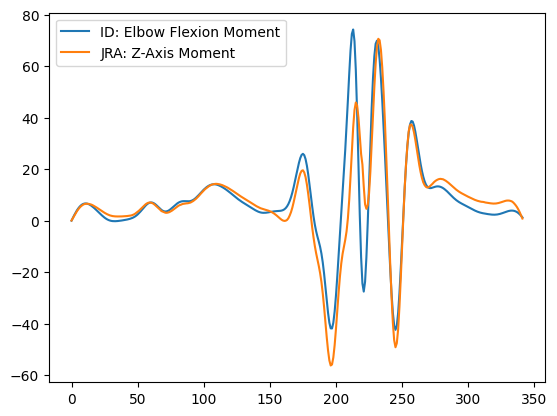

In [108]:
# load test files
test_id_results = pd.read_csv('trial_moments.sto', sep='\s+', skiprows=6)
test_jra_results = pd.read_csv('trial_jra_JointReactionAnalysis_ReactionLoads.sto', sep='\s+', skiprows=11)

# plots
test_id_results['elbow_flex_r_moment'].plot()
test_jra_results['elbow_r_on_ulna_r_in_ulna_r_mz'].plot()

plt.legend(['ID: Elbow Flexion Moment', 'JRA: Z-Axis Moment'])
plt.show()

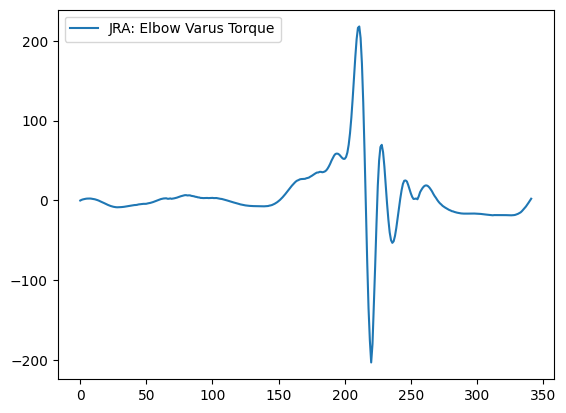

In [109]:
test_jra_results['elbow_r_on_ulna_r_in_ulna_r_mx'].plot()
plt.legend(['JRA: Elbow Varus Torque'])